In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import AdaBoostRegressor

# Ignore warning
pd.options.mode.chained_assignment = None  # default='warn'

# Import csv file
demand_data = "C:/Users/javin/Desktop/HPD.csv"
data = pd.read_csv(demand_data)
df = pd.DataFrame(data)

# Display data
print(df.head(5))
print('')
print('Dimension of data', df.shape)

   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 

Dimension of data (1048575, 5)


In [2]:
# Count number of products in total based on 'Product_Code'
Counter(df['Product_Code']).keys()
prod_count = Counter(df['Product_Code']).values()
print("Product count =", len(prod_count))
print()

# Most frequent items with dimensions
print('Most frequent product:', df['Product_Code']. value_counts(). idxmax())
print('Most frequent category:',df['Product_Category']. value_counts(). idxmax())

P1359 = df[df.Product_Code.eq('Product_1359')]
print('Dimension of Product_1359:', P1359.shape)
C019 = df[df.Product_Category.eq('Category_019')]
print('Dimension of Category_019:',C019.shape)

Product count = 2160

Most frequent product: Product_1359
Most frequent category: Category_019
Dimension of Product_1359: (16936, 5)
Dimension of Category_019: (481099, 5)


In [3]:
#Determine rows with missing values
missingcol = df.isna().sum()
print("% of Data missing =", missingcol.sum()/len(df)*100)

% of Data missing = 1.0718355863910547


In [4]:
## Preprocess data
# Remove row with missing values
df.dropna(inplace=True)
print('Missing value?', df.isnull().values.any())
print('')

# Convert 'Date' from string to timestamp
df['Date'] = pd.to_datetime(df['Date'])

# # Remove bracket in 'Order_Demand' column
df['Order_Demand']=df['Order_Demand'].str.replace('(',"")
df['Order_Demand']=df['Order_Demand'].str.replace(')',"")

# # Convert 'Order_Demand' from string to integer data type
df['Order_Demand']=df['Order_Demand'].astype(int)

# Display data after removed missing values & timestamp conversion
print('After removed missing values and timestamp conversion:')
print(df.head(5))
print('')
print(df.shape)

Missing value? False



<ipython-input-4-d99b9647db82>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand']=df['Order_Demand'].str.replace('(',"")
<ipython-input-4-d99b9647db82>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand']=df['Order_Demand'].str.replace(')',"")


After removed missing values and timestamp conversion:
   Product_Code Warehouse Product_Category       Date  Order_Demand
0  Product_0993    Whse_J     Category_028 2012-07-27           100
1  Product_0979    Whse_J     Category_028 2012-01-19           500
2  Product_0979    Whse_J     Category_028 2012-02-03           500
3  Product_0979    Whse_J     Category_028 2012-02-09           500
4  Product_0979    Whse_J     Category_028 2012-03-02           500

(1037336, 5)


In [5]:
# Sort date
df2 = df.sort_values('Date')
print(df2.head(10))

        Product_Code Warehouse Product_Category       Date  Order_Demand
44799   Product_0965    Whse_A     Category_006 2011-01-08             2
72252   Product_1724    Whse_A     Category_003 2011-05-31           108
8431    Product_1521    Whse_S     Category_019 2011-06-24         85000
8432    Product_1521    Whse_S     Category_019 2011-06-24          7000
72669   Product_1507    Whse_C     Category_019 2011-09-02          1250
17249   Product_0608    Whse_C     Category_001 2011-09-27             5
17250   Product_1933    Whse_C     Category_001 2011-09-27            23
74615   Product_0875    Whse_C     Category_023 2011-09-30          5450
131426  Product_0125    Whse_S     Category_011 2011-10-20             2
131429  Product_0412    Whse_S     Category_007 2011-10-20             2


In [6]:
# Data downsampling to weekly record (Phase 1: Change the date to weekly record which ends on Sunday of each week)
weekly_demand_data = df2.groupby('Date').resample('W', label='right', closed='right', on='Date').sum()
print(weekly_demand_data.head(5))
print(weekly_demand_data.shape) # The date was not included in the dataframe

# Data downsampling to weekly record (Phase 2 - Save to xlsx file as the date cannot be retained)
writer = pd.ExcelWriter('Weekly_Demand.xlsx')
weekly_demand_data.to_excel(writer)
writer.save()

                       Order_Demand
Date       Date                    
2011-01-08 2011-01-09             2
2011-05-31 2011-06-05           108
2011-06-24 2011-06-26         92000
2011-09-02 2011-09-04          1250
2011-09-27 2011-10-02            28
(1729, 1)


In [7]:
# Data downsampling to weekly record (Phase 3 - Read xlsx file to retain the date)
WD = pd.read_excel('Weekly_Demand.xlsx')
df3 = pd.DataFrame(WD)

df3.drop(df3.columns[0], axis=1, inplace=True)
df4 = df3.rename(columns={'Date.1': 'Date'})
print(df4.head(5))
print(df4.shape)

        Date  Order_Demand
0 2011-01-09             2
1 2011-06-05           108
2 2011-06-26         92000
3 2011-09-04          1250
4 2011-10-02            28
(1729, 2)


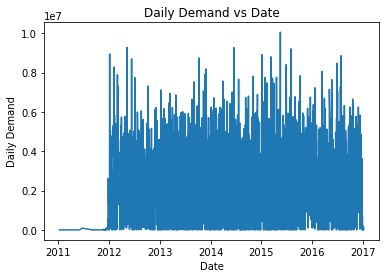

In [8]:
df_daily = df[['Date', 'Order_Demand']]
df_daily1 = df_daily.sort_values('Date')
df_daily1['Daily_Demand'] = df_daily1.groupby(['Date'])['Order_Demand'].transform('sum')
df_daily1.drop(df_daily1.columns[1], axis=1, inplace=True)
df_daily2 = df_daily1.drop_duplicates(subset=['Date'])

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(df_daily2)

dailydata = pd.ExcelWriter('Graph_of_Daily_Data.xlsx')
df_daily2.to_excel(dailydata)
dailydata.save()
    
# Plot graph for daily demand (Total)
X_graph = df_daily2['Date']
y_graph = df_daily2['Daily_Demand']
plt.plot(X_graph, y_graph)
plt.title('Daily Demand vs Date')
plt.xlabel('Date')
plt.ylabel('Daily Demand')
plt.show()


In [9]:
# Sum of demand based on the duplicate weekdate 
df4['Weekly_Demand'] = df4.groupby(['Date'])['Order_Demand'].transform('sum')

# Remove duplicate columns
df4.drop(df4.columns[1], axis=1, inplace=True)

df5 = df4.drop_duplicates(subset=['Date'])
print(df5)

           Date  Weekly_Demand
0    2011-01-09              2
1    2011-06-05            108
2    2011-06-26          92000
3    2011-09-04           1250
4    2011-10-02           5478
...         ...            ...
1706 2016-12-18       19919049
1712 2016-12-25       17479550
1718 2017-01-01        9276335
1723 2017-01-08         290789
1728 2017-01-15           4178

[277 rows x 2 columns]


In [10]:
df7 = df5
df7['log_Weekly_Demand'] = np.log(df7['Weekly_Demand'])
df7['Year'] = pd. DatetimeIndex(df7['Date']). year
df7['Week'] = df7['Date'].dt.week
df7.head(5)

<ipython-input-10-5f3632fba6f6>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df7['Week'] = df7['Date'].dt.week


,Date,Weekly_Demand,log_Weekly_Demand,Year,Week
0,2011-01-09,2,0.693147,2011,1
1,2011-06-05,108,4.682131,2011,22
2,2011-06-26,92000,11.429544,2011,25
3,2011-09-04,1250,7.130899,2011,35
4,2011-10-02,5478,8.608495,2011,39


In [11]:
weeklydata = pd.ExcelWriter('Graph_of_Weekly_Data.xlsx')
df7.to_excel(weeklydata)
weeklydata.save()

In [12]:
# Define X and y for Training, Validation and Testing Set
X = df7.drop(['Date', 'Weekly_Demand', 'log_Weekly_Demand'], axis=1)
y = df7['log_Weekly_Demand']
# X.reshape(1,-1)
print(X.head(5))
print()
print(y.head(5))

   Year  Week
0  2011     1
1  2011    22
2  2011    25
3  2011    35
4  2011    39

0     0.693147
1     4.682131
2    11.429544
3     7.130899
4     8.608495
Name: log_Weekly_Demand, dtype: float64


In [13]:
# Save the processed data for NARNN modelling in MATLAB
df8 = df7[['Year', 'Week', 'Weekly_Demand', 'log_Weekly_Demand']]
print(df8.head(5))
print(df8.shape)

writer3 = pd.ExcelWriter('Processed_Data_Weekly_Demand.xlsx')
df8.to_excel(writer3)
writer3.save()

   Year  Week  Weekly_Demand  log_Weekly_Demand
0  2011     1              2           0.693147
1  2011    22            108           4.682131
2  2011    25          92000          11.429544
3  2011    35           1250           7.130899
4  2011    39           5478           8.608495
(277, 4)


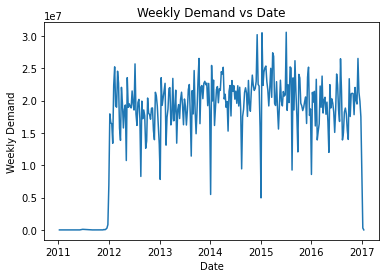

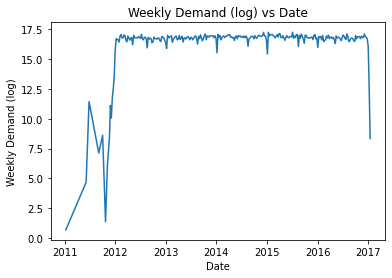

In [14]:
# Plot graph for weekly demand (Total)
X_graph = df7['Date']
y_graph = df7['Weekly_Demand']
plt.plot(X_graph, y_graph)
plt.title('Weekly Demand vs Date')
plt.xlabel('Date')
plt.ylabel('Weekly Demand')
plt.show()

X_graph1 = df7['Date']
y_graph1 = df7['log_Weekly_Demand']
plt.plot(X_graph1, y_graph1)
plt.title('Weekly Demand (log) vs Date')
plt.xlabel('Date')
plt.ylabel('Weekly Demand (log)')
plt.show()

In [15]:
# Category_019 (Most Frequent Category)
cat019 = df2[df2.Product_Category.eq('Category_019')]
print(cat019.shape)
print('')
df019 = cat019.groupby('Date').resample('W', label='right', closed='right', on='Date').sum()
print(df019.head(5))
print(df019.shape)
print('')

writer1 = pd.ExcelWriter('Weekly_Demand_Category019.xlsx')
df019.to_excel(writer1)
writer1.save()

df_new = pd.read_excel('Weekly_Demand_Category019.xlsx')
dff = pd.DataFrame(df_new)

dff.drop(dff.columns[0], axis=1, inplace=True)
dff1 = dff.rename(columns={'Date.1': 'Date'})
print(dff1.head(5))
print(dff1.shape)

dff1['Weekly_Demand'] = dff1.groupby(['Date'])['Order_Demand'].transform('sum')
dff1.drop(dff1.columns[1], axis=1, inplace=True)
print(dff1)

dff2 = dff1.drop_duplicates(subset=['Date'])
print(dff2)

(470266, 5)

                       Order_Demand
Date       Date                    
2011-06-24 2011-06-26         92000
2011-09-02 2011-09-04          1250
2011-10-31 2011-11-06             3
2011-11-24 2011-11-27         40000
2011-11-25 2011-11-27         17250
(1606, 1)

        Date  Order_Demand
0 2011-06-26         92000
1 2011-09-04          1250
2 2011-11-06             3
3 2011-11-27         40000
4 2011-11-27         17250
(1606, 2)
           Date  Weekly_Demand
0    2011-06-26          92000
1    2011-09-04           1250
2    2011-11-06              3
3    2011-11-27          57250
4    2011-11-27          57250
...         ...            ...
1601 2017-01-01        7303072
1602 2017-01-08         206800
1603 2017-01-08         206800
1604 2017-01-08         206800
1605 2017-01-15           4000

[1606 rows x 2 columns]
           Date  Weekly_Demand
0    2011-06-26          92000
1    2011-09-04           1250
2    2011-11-06              3
3    2011-11-27          57250


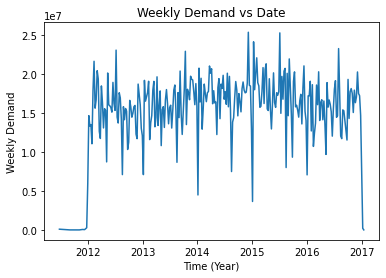

In [16]:
# Plot for Category_019
X1 = dff2['Date']
y1 = dff2['Weekly_Demand']

plt.plot(X1,y1)
plt.title('Weekly Demand vs Date')
plt.xlabel('Time (Year)')
plt.ylabel('Weekly Demand')
plt.show()

In [17]:
# Product_1359 (Most Frequent Product)
prod1359 = df2[df2.Product_Code.eq('Product_1359')]
print(prod1359.shape)
print('')
df1359 = prod1359.groupby('Date').resample('W', label='right', closed='right', on='Date').sum()
print(df1359.head(5))
print(df1359.shape)
print('')

writer2 = pd.ExcelWriter('Weekly_Demand_Product1359.xlsx')
df1359.to_excel(writer2)
writer2.save()

df_new1 = pd.read_excel('Weekly_Demand_Product1359.xlsx')
df1359_1 = pd.DataFrame(df_new1)

df1359_1.drop(df1359_1.columns[0], axis=1, inplace=True)
df1359_2 = df1359_1.rename(columns={'Date.1': 'Date'})
print(df1359_2.head(5))
print(df1359_2.shape)

df1359_2['Weekly_Demand'] = df1359_2.groupby(['Date'])['Order_Demand'].transform('sum')
df1359_2.drop(df1359_2.columns[1], axis=1, inplace=True)
print(df1359_2)

df1359_3 = df1359_2.drop_duplicates(subset=['Date'])
print(df1359_3)

(16936, 5)

                       Order_Demand
Date       Date                    
2012-01-05 2012-01-08        702000
2012-01-06 2012-01-08        676000
2012-01-10 2012-01-15        783000
2012-01-11 2012-01-15        200000
2012-01-12 2012-01-15        284000
(1232, 1)

        Date  Order_Demand
0 2012-01-08        702000
1 2012-01-08        676000
2 2012-01-15        783000
3 2012-01-15        200000
4 2012-01-15        284000
(1232, 2)
           Date  Weekly_Demand
0    2012-01-08        1378000
1    2012-01-08        1378000
2    2012-01-15        1799000
3    2012-01-15        1799000
4    2012-01-15        1799000
...         ...            ...
1227 2016-12-25        1189000
1228 2017-01-01         516000
1229 2017-01-01         516000
1230 2017-01-01         516000
1231 2017-01-08         100000

[1232 rows x 2 columns]
           Date  Weekly_Demand
0    2012-01-08        1378000
2    2012-01-15        1799000
6    2012-01-22        1710000
11   2012-01-29        2171000
1

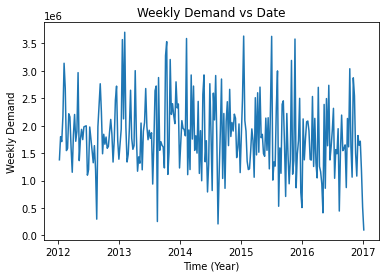

In [18]:
# Plot for Product_1359
X2 = df1359_3['Date']
y2 = df1359_3['Weekly_Demand']

plt.plot(X2,y2)
plt.title('Weekly Demand vs Date')
plt.xlabel('Time (Year)')
plt.ylabel('Weekly Demand')
plt.show()

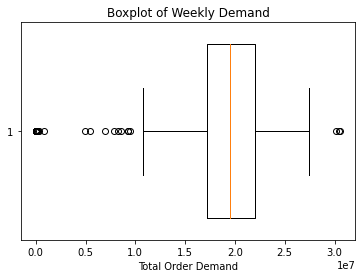

In [19]:
plt.boxplot(df7['Weekly_Demand'], vert=False, widths=0.8)
plt.title('Boxplot of Weekly Demand')
plt.xlabel('Total Order Demand')
plt.show()

In [20]:
# Train test split (70% train, 25% valid, 5% test)
# x_train, x_int, y_train, y_int = train_test_split(X, y, train_size=0.702)
# x_valid, x_test, y_valid, y_test = train_test_split(x_int, y_int, train_size=0.8333)

# print('X: ', len(X))
# print('y: ', len(y))

# print('x_train: ', len(x_train))
# print('y_train: ', len(y_train))

# print('x_valid: ', len(x_valid))
# print('y_valid: ', len(y_valid))

# print('x_test: ', len(x_test))
# print('y_test: ', len(y_test))

In [21]:
x_train = X[:194]
y_train = y[:194]

x_int = X[194:]
y_int = y[194:]

x_valid = x_int[:69]
y_valid = y_int[:69]

x_test = x_int[69:]
y_test = y_int[69:]

print('X: ', len(X))
print('y: ', len(y))

print('x_train: ', len(x_train))
print('y_train: ', len(y_train))

print('x_int: ', len(x_int))
print('y_int: ', len(y_int))

print('x_valid: ', len(x_valid))
print('y_valid: ', len(y_valid))

print('x_test: ', len(x_test))
print('y_test: ', len(y_test))

X:  277
y:  277
x_train:  194
y_train:  194
x_int:  83
y_int:  83
x_valid:  69
y_valid:  69
x_test:  14
y_test:  14


In [22]:
# 275 instances
X1 = X[:275]
y1 = y[:275]

x_train1 = X1[:192]
y_train1 = y1[:192]

x_int1 = X1[192:]
y_int1 = y1[192:]

x_valid1 = x_int1[:69]
y_valid1 = y_int1[:69]

x_test1 = x_int1[69:]
y_test1 = y_int1[69:]

print('X1: ', len(X1))
print('y1: ', len(y1))

print('x_train1: ', len(x_train1))
print('y_train1: ', len(y_train1))

print('x_int1: ', len(x_int1))
print('y_int1: ', len(y_int1))

print('x_valid1: ', len(x_valid1))
print('y_valid1: ', len(y_valid1))

print('x_test1: ', len(x_test1))
print('y_test1: ', len(y_test1))

X1:  275
y1:  275
x_train1:  192
y_train1:  192
x_int1:  83
y_int1:  83
x_valid1:  69
y_valid1:  69
x_test1:  14
y_test1:  14


In [23]:
# 262 instances
X1 = X[13:275]
y1 = y[13:275]

x_train1 = X1[:183]
y_train1 = y1[:183]

x_int1 = X1[183:]
y_int1 = y1[183:]

x_valid1 = x_int1[:66]
y_valid1 = y_int1[:66]

x_test1 = x_int1[66:]
y_test1 = y_int1[66:]

print('X1: ', len(X1))
print('y1: ', len(y1))

print('x_train1: ', len(x_train1))
print('y_train1: ', len(y_train1))

print('x_int1: ', len(x_int1))
print('y_int1: ', len(y_int1))

print('x_valid1: ', len(x_valid1))
print('y_valid1: ', len(y_valid1))

print('x_test1: ', len(x_test1))
print('y_test1: ', len(y_test1))

X1:  262
y1:  262
x_train1:  183
y_train1:  183
x_int1:  79
y_int1:  79
x_valid1:  66
y_valid1:  66
x_test1:  13
y_test1:  13


In [24]:
y.describe()

count    277.000000
mean      16.320314
std        2.077131
min        0.693147
25%       16.662894
50%       16.784095
75%       16.907767
max       17.235373
Name: log_Weekly_Demand, dtype: float64

In [25]:
y1.describe()

count    262.000000
mean      16.764473
std        0.246965
min       15.415659
25%       16.695918
50%       16.792474
75%       16.913453
max       17.235373
Name: log_Weekly_Demand, dtype: float64

In [26]:
X1

,Year,Week
36,2012,52
43,2012,1
49,2012,2
55,2012,3
62,2012,4
...,...,...
1694,2016,48
1700,2016,49
1706,2016,50
1712,2016,51


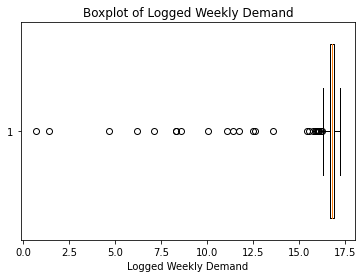

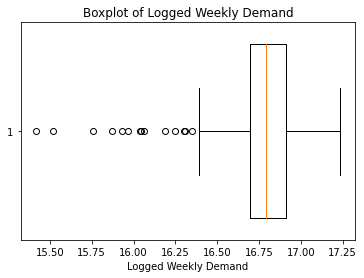

In [27]:
plt.boxplot(y, vert=False, widths=0.8)
plt.title('Boxplot of Logged Weekly Demand')
plt.xlabel('Logged Weekly Demand')
plt.show()

plt.boxplot(y1, vert=False, widths=0.8)
plt.title('Boxplot of Logged Weekly Demand')
plt.xlabel('Logged Weekly Demand')
plt.show()

In [28]:
#SVM model valid (Ori)
print("Support Vector Regression Algorithms:")
print()
kernel = ["linear", "poly", "rbf", "sigmoid"]
for i in kernel:
    regr = SVR(kernel = i)
    regr.fit(x_train, y_train)
    
    # predictions
    predictions = regr.predict(x_valid)
    print('Kernel : ', i, '-------------')
    mse = mean_squared_error(y_valid, predictions)
    rmse = math.sqrt(mse)
    print("RMSE   : ", format(mse, ".4f"))
    mape = mean_absolute_percentage_error(y_valid, predictions)
    print("MAPE   : ", format(mape, ".4f"))
    print("")

Support Vector Regression Algorithms:

Kernel :  linear -------------
RMSE   :  0.1120
MAPE   :  0.0159

Kernel :  poly -------------
RMSE   :  0.0514
MAPE   :  0.0097

Kernel :  rbf -------------
RMSE   :  0.0514
MAPE   :  0.0097

Kernel :  sigmoid -------------
RMSE   :  0.0514
MAPE   :  0.0097



In [29]:
#SVM model valid (Ignore trend variation)
print("Support Vector Regression Algorithms:")
print()
kernel = ["linear", "poly", "rbf", "sigmoid"]
for i in kernel:
    regr = SVR(kernel = i)
    regr.fit(x_train1, y_train1)
    
    # predictions
    predictions = regr.predict(x_valid1)
    print('Kernel : ', i, '-------------')
    mse = mean_squared_error(y_valid1, predictions)
    rmse = math.sqrt(mse)
    print("RMSE   : ", format(mse, ".4f"))
    mape = mean_absolute_percentage_error(y_valid1, predictions)
    print("MAPE   : ", format(mape, ".4f"))
    print("")

Support Vector Regression Algorithms:

Kernel :  linear -------------
RMSE   :  0.0910
MAPE   :  0.0138

Kernel :  poly -------------
RMSE   :  0.0550
MAPE   :  0.0102

Kernel :  rbf -------------
RMSE   :  0.0549
MAPE   :  0.0102

Kernel :  sigmoid -------------
RMSE   :  0.0548
MAPE   :  0.0101



In [30]:
#SVM model test (ori)
print("Support Vector Regression Algorithms:")
print()
kernel = ["linear", "poly", "rbf", "sigmoid"]
for i in kernel:
    regr = SVR(kernel = i)
    regr.fit(x_train, y_train)
    
    # predictions
    predictions = regr.predict(x_test)
    print('Kernel : ', i, '-------------')
    mse = mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    print("RMSE   : ", format(mse, ".4f"))
    mape = mean_absolute_percentage_error(y_test, predictions)
    print("MAPE   : ", format(mape, ".4f"))
    print("")

Support Vector Regression Algorithms:

Kernel :  linear -------------
RMSE   :  7.1382
MAPE   :  0.1150

Kernel :  poly -------------
RMSE   :  6.4731
MAPE   :  0.1044

Kernel :  rbf -------------
RMSE   :  6.4402
MAPE   :  0.1039

Kernel :  sigmoid -------------
RMSE   :  6.4278
MAPE   :  0.1038



In [31]:
#SVM model test (ignore trend variations)
print("Support Vector Regression Algorithms:")
print()
kernel = ["linear", "poly", "rbf", "sigmoid"]
for i in kernel:
    regr = SVR(kernel = i)
    regr.fit(x_train1, y_train1)
    
    # predictions
    predictions = regr.predict(x_valid1)
    print('Kernel : ', i, '-------------')
    mse = mean_squared_error(y_valid1, predictions)
    rmse = math.sqrt(mse)
    print("RMSE   : ", format(mse, ".4f"))
    mape = mean_absolute_percentage_error(y_valid1, predictions)
    print("MAPE   : ", format(mape, ".4f"))
    print("")

Support Vector Regression Algorithms:

Kernel :  linear -------------
RMSE   :  0.0910
MAPE   :  0.0138

Kernel :  poly -------------
RMSE   :  0.0550
MAPE   :  0.0102

Kernel :  rbf -------------
RMSE   :  0.0549
MAPE   :  0.0102

Kernel :  sigmoid -------------
RMSE   :  0.0548
MAPE   :  0.0101



In [32]:
# Artificial Neural Network
print("Artificial Neural Network Algorithms:")
print()

activation = ["identity", "logistic", "tanh", "relu"]
for i in activation:
    ann = MLPRegressor(hidden_layer_sizes = (5,2), activation = i, solver = 'adam', learning_rate_init=0.001, max_iter = 100000)
    ann.fit(x_train, y_train)
    
    # predictions
    predictions = regr.predict(x_test)
    print('Activation : ', i, '-------------')
    mse = mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    print("RMSE       : ", format(mse, ".4f"))
    mape = mean_absolute_percentage_error(y_test, predictions)
    print("MAPE       : ", format(mape, ".4f"))
    print("")


Artificial Neural Network Algorithms:

Activation :  identity -------------
RMSE       :  6.4558
MAPE       :  0.1038

Activation :  logistic -------------
RMSE       :  6.4558
MAPE       :  0.1038

Activation :  tanh -------------
RMSE       :  6.4558
MAPE       :  0.1038

Activation :  relu -------------
RMSE       :  6.4558
MAPE       :  0.1038



In [33]:
# Gradient Boosting Regressor valid (ori)

params = {'learning_rate': 0.001,
          'loss': 'least_absolute_deviation'}

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(x_train, y_train)

gbr_result = gbr.predict(x_valid)

gbr_mse = mean_squared_error(y_valid, gbr_result)
gbr_rmse = math.sqrt(gbr_mse)
print("Gradient Boosting Regressor")
print("RMSE : ", format(gbr_rmse, ".4f"))
gbr_mape = mean_absolute_percentage_error(y_valid, gbr_result)
print("MAPE : ", format(gbr_mape, ".4f"))


Gradient Boosting Regressor
RMSE :  0.2263
MAPE :  0.0097


In [34]:
# Gradient Boosting Regressor valid (ignore trend variations)

params = {'learning_rate': 0.001,
          'loss': 'poisson'}

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(x_train1, y_train1)

gbr_result = gbr.predict(x_valid1)

gbr_mse = mean_squared_error(y_valid1, gbr_result)
gbr_rmse = math.sqrt(gbr_mse)
print("Gradient Boosting Regressor")
print("RMSE : ", format(gbr_rmse, ".4f"))
gbr_mape = mean_absolute_percentage_error(y_valid1, gbr_result)
print("MAPE : ", format(gbr_mape, ".4f"))


Gradient Boosting Regressor
RMSE :  0.2288
MAPE :  0.0099


In [35]:
# Gradient Boosting Regressor test (ori)

params = {'learning_rate': 0.001,
          'loss': 'least_absolute_deviation'}

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(x_train, y_train)

gbr_result = gbr.predict(x_test)

gbr_mse = mean_squared_error(y_test, gbr_result)
gbr_rmse = math.sqrt(gbr_mse)
print("Gradient Boosting Regressor")
print("RMSE : ", format(gbr_rmse, ".4f"))
gbr_mape = mean_absolute_percentage_error(y_test, gbr_result)
print("MAPE : ", format(gbr_mape, ".4f"))


Gradient Boosting Regressor
RMSE :  2.5357
MAPE :  0.1038


In [36]:
# Gradient Boosting Regressor test (ignore trend variations)

params = {'learning_rate': 0.001,
          'loss': 'poisson'}

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(x_train1, y_train1)

gbr_result = gbr.predict(x_test1)

gbr_mse = mean_squared_error(y_test1, gbr_result)
gbr_rmse = math.sqrt(gbr_mse)
print("Gradient Boosting Regressor")
print("RMSE : ", format(gbr_rmse, ".4f"))
gbr_mape = mean_absolute_percentage_error(y_test1, gbr_result)
print("MAPE : ", format(gbr_mape, ".4f"))

Gradient Boosting Regressor
RMSE :  0.2348
MAPE :  0.0088


In [37]:
# Gradient Boosting Regressor test (ignore trend variations)

params = {'learning_rate': 0.001,
          'loss': 'poisson'}

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(x_train1, y_train1)

gbr_result = gbr.predict(x_test1)

gbr_mse = mean_squared_error(y_test1, gbr_result)
gbr_rmse = math.sqrt(gbr_mse)
print("Gradient Boosting Regressor")
print("RMSE : ", format(gbr_rmse, ".4f"))
gbr_mape = mean_absolute_percentage_error(y_test1, gbr_result)
print("MAPE : ", format(gbr_mape, ".4f"))


Gradient Boosting Regressor
RMSE :  0.2348
MAPE :  0.0088


In [38]:
# AdaBoost Regressor test (valid)

ada = AdaBoostRegressor(learning_rate=0.001,loss='exponential', random_state=0)
ada.fit(x_train1,y_train1)

ada_result = ada.predict(x_valid1)

ada_mse = mean_squared_error(y_valid1,ada_result)
ada_rmse = math.sqrt(ada_mse)
print("AdaBoost Regressor")
print("RMSE : ", format(ada_rmse, ".4f"))
ada_mape = mean_absolute_percentage_error(y_valid1,ada_result)
print("MAPE : ", format(ada_mape, ".4f"))

AdaBoost Regressor
RMSE :  0.2970
MAPE :  0.0119


In [39]:
# AdaBoost Regressor test (test)

ada = AdaBoostRegressor(learning_rate=0.1,loss='linear', random_state=0)
ada.fit(x_train1,y_train1)

ada_result = ada.predict(x_test1)

ada_mse = mean_squared_error(y_test1,ada_result)
ada_rmse = math.sqrt(ada_mse)
print("AdaBoost Regressor")
print("RMSE : ", format(ada_rmse, ".4f"))
ada_mape = mean_absolute_percentage_error(y_test1,ada_result)
print("MAPE : ", format(ada_mape, ".4f"))

AdaBoost Regressor
RMSE :  0.2193
MAPE :  0.0080


In [122]:
y_test1

1642    16.679880
1649    16.862183
1656    16.866248
1661    16.863464
1668    16.695802
1675    16.907767
1681    16.813234
1688    16.784095
1694    17.093159
1700    16.874057
1706    16.807187
1712    16.676542
1718    16.042977
Name: log_Weekly_Demand, dtype: float64

In [123]:
ada_result

array([16.8461792 , 16.8461792 , 16.8461792 , 16.8461792 , 16.8461792 ,
       16.8461792 , 16.8461792 , 16.8461792 , 16.8461792 , 16.8461792 ,
       16.8461792 , 16.8461792 , 16.76348164])

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from numpy.random import seed
seed(1)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset.iloc[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset.iloc[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

y_train2 = pd.DataFrame(y_train1)
y_valid2 = pd.DataFrame(y_valid1)
y_test2 = pd.DataFrame(y_test1)

look_back = 2
trainX, trainY = create_dataset(y_train2, look_back)
validX, validY = create_dataset(y_valid2, look_back)
testX, testY = create_dataset(y_test2, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.4f RMSE' % (trainScore))
# validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
# print('Valid Score: %.4f RMSE' % (validScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.4f RMSE' % (testScore))

# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY, validPredict[:,0]))
print('Valid Score: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))



Epoch 1/100
180/180 - 0s - loss: 189.7300
Epoch 2/100
180/180 - 0s - loss: 70.0582
Epoch 3/100
180/180 - 0s - loss: 19.5920
Epoch 4/100
180/180 - 0s - loss: 6.0852
Epoch 5/100
180/180 - 0s - loss: 1.6104
Epoch 6/100
180/180 - 0s - loss: 0.3774
Epoch 7/100
180/180 - 0s - loss: 0.1104
Epoch 8/100
180/180 - 0s - loss: 0.0660
Epoch 9/100
180/180 - 0s - loss: 0.0605
Epoch 10/100
180/180 - 0s - loss: 0.0600
Epoch 11/100
180/180 - 0s - loss: 0.0598
Epoch 12/100
180/180 - 0s - loss: 0.0599
Epoch 13/100
180/180 - 0s - loss: 0.0599
Epoch 14/100
180/180 - 0s - loss: 0.0600
Epoch 15/100
180/180 - 0s - loss: 0.0600
Epoch 16/100
180/180 - 0s - loss: 0.0603
Epoch 17/100
180/180 - 0s - loss: 0.0599
Epoch 18/100
180/180 - 0s - loss: 0.0605
Epoch 19/100
180/180 - 0s - loss: 0.0602
Epoch 20/100
180/180 - 0s - loss: 0.0603
Epoch 21/100
180/180 - 0s - loss: 0.0602
Epoch 22/100
180/180 - 0s - loss: 0.0606
Epoch 23/100
180/180 - 0s - loss: 0.0603
Epoch 24/100
180/180 - 0s - loss: 0.0603
Epoch 25/100
180/180 

In [118]:
import tensorflow

m = tensorflow.keras.metrics.MeanAbsolutePercentageError()
m.update_state(validY, validPredict[:,0])
m.result().numpy()

0.9895322

In [119]:
import tensorflow

m = tensorflow.keras.metrics.MeanAbsolutePercentageError()
m.update_state(testY, testPredict[:,0])
m.result().numpy()

0.73448086

In [120]:
print(testY)
print(testPredict)

[16.8662475  16.86346443 16.69580196 16.90776741 16.81323435 16.78409509
 17.09315871 16.87405673 16.80718707 16.67654218]
[[16.732159]
 [16.73249 ]
 [16.732492]
 [16.732138]
 [16.73228 ]
 [16.732462]
 [16.732235]
 [16.732807]
 [16.732897]
 [16.732391]]
